
**Import data from Google Drive**

In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

40069772/40069772 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2120


Populating the interactive namespace from numpy and matplotlib
Shape of the image (72307,)


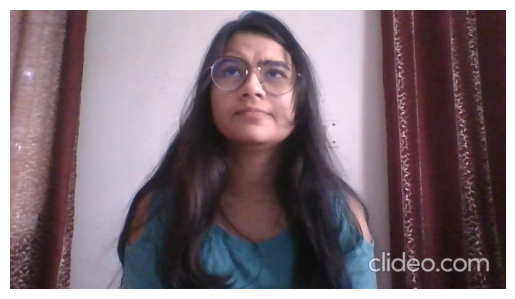

Shape of the image (19745,)


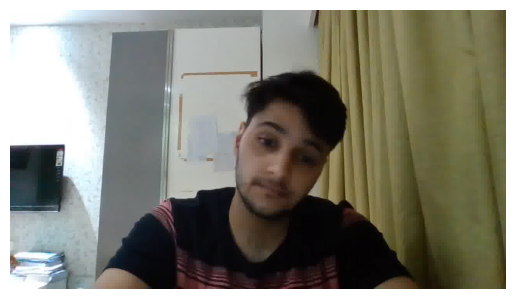

Shape of the image (21216,)


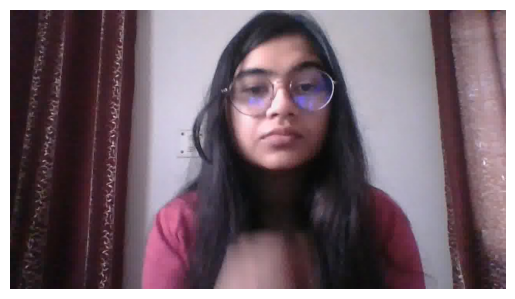

Shape of the image (21813,)


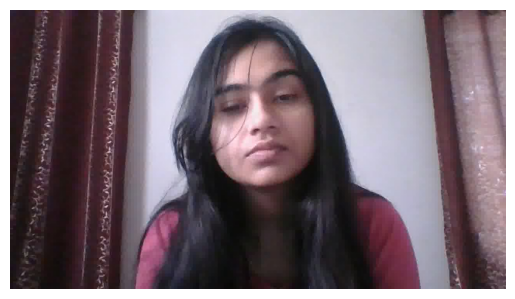

Shape of the image (17353,)


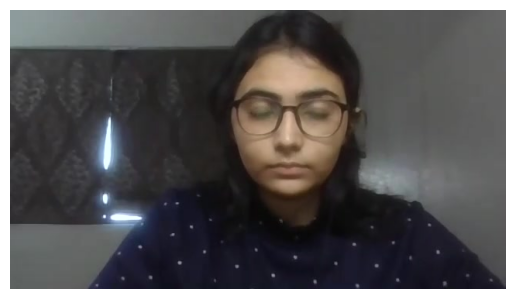

Shape of the image (44759,)


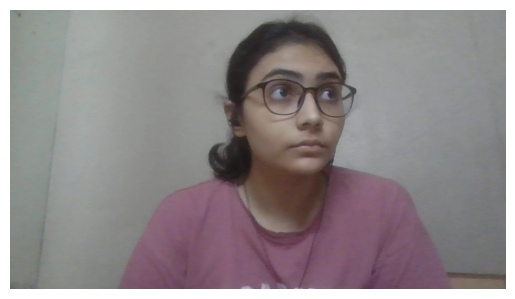

In [4]:
%pylab inline
#learner confused
url_confused = r'https://github.com/ayarii/learner-engagement/blob/main/0020.jpg?raw=true'
resp = requests.get(url_confused, stream=True).raw
image_array_confused = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_confused.shape}')
image_confused = cv2.imdecode(image_array_confused, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_confused, cv2.COLOR_BGR2RGB))
plt.show()

#learner frustrated
url_frustrated = r'https://github.com/ayarii/learner-engagement/blob/main/135.jpg?raw=true'
resp = requests.get(url_frustrated, stream=True).raw
image_array_frustrated= np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_frustrated.shape}')
image_frustrated = cv2.imdecode(image_array_frustrated, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_frustrated, cv2.COLOR_BGR2RGB))
plt.show()

#learner engaged
url_engaged = r'https://github.com/ayarii/learner-engagement/blob/main/0076.jpg?raw=true'
resp = requests.get(url_engaged, stream=True).raw
image_array_engagement = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_engagement.shape}')
image_engagement = cv2.imdecode(image_array_engagement, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
plt.show()

#learner bored
url_bored = r'https://github.com/ayarii/learner-engagement/blob/main/0153.jpg?raw=true'
resp = requests.get(url_bored, stream=True).raw
image_array_bored = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_bored.shape}')
image_bored = cv2.imdecode(image_array_bored, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_bored, cv2.COLOR_BGR2RGB))
plt.show()

#learner drowsy
url_drowsy = r'https://github.com/ayarii/learner-engagement/blob/main/0021.jpg?raw=true'
resp = requests.get(url_drowsy, stream=True).raw
image_array_drowsy = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_drowsy.shape}')
image_drowsy = cv2.imdecode(image_array_drowsy, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_drowsy, cv2.COLOR_BGR2RGB))
plt.show()

# learner looking_away
url_looking_away = r'https://github.com/ayarii/learner-engagement/blob/main/0011.jpg?raw=true'
resp = requests.get(url_looking_away, stream=True).raw
image_array_looking_away = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_looking_away.shape}')
image_looking_away = cv2.imdecode(image_array_looking_away, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_looking_away, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
# Image dimensions and batch size
img_height = 200
img_width = 200
batch_size = 32

# Create the training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


# Create the validation dataset
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Get the file paths
file_paths = train_data.file_paths

# Print the first 10 file paths
for path in file_paths[:10]:
    print(path)

Found 2120 files belonging to 6 classes.
Using 1696 files for training.
Found 2120 files belonging to 6 classes.
Using 424 files for validation.
/content/datasets/Student-engagement-dataset/confused/0061.jpg
/content/datasets/Student-engagement-dataset/drowsy/0463.jpg
/content/datasets/Student-engagement-dataset/Looking Away/0354.jpg
/content/datasets/Student-engagement-dataset/engaged/0314.jpg
/content/datasets/Student-engagement-dataset/frustrated/0197.jpg
/content/datasets/Student-engagement-dataset/frustrated/0216.jpg
/content/datasets/Student-engagement-dataset/drowsy/0033.jpg
/content/datasets/Student-engagement-dataset/engaged/0397.jpg
/content/datasets/Student-engagement-dataset/bored/0148.jpg
/content/datasets/Student-engagement-dataset/drowsy/0245.jpg


In [39]:
num_classes = 6
img_size = (200, 200,3)
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Set up callbacks
log_dir = "logs/"
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping]
)
# Evaluate the model
loss, accuracy = model.evaluate(val_data, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 8s 106ms/step - loss: 0.4746 - accuracy: 0.8219 - val_loss: 0.1845 - val_accuracy: 0.8915
Epoch 2/100
53/53 [==============================] - 6s 102ms/step - loss: 0.1078 - accuracy: 0.9487 - val_loss: 0.1072 - val_accuracy: 0.9269
Epoch 3/100
53/53 [==============================] - 7s 117ms/step - loss: 0.0878 - accuracy: 0.9558 - val_loss: 0.1348 - val_accuracy: 0.9269
Epoch 4/100
53/53 [==============================] - 6s 103ms/step - loss: 0.0787 - accuracy: 0.9605 - val_loss: 0.0974 - val_accuracy: 0.9458
Epoch 5/100
53/53 [==============================] - 8s 139ms/step - loss: 0.0756 - accuracy: 0.9629 - val_loss: 0.1112 - val_accuracy: 0.9575
Epoch 6/100
53/53 [==============================] - 11s 206ms/step - loss: 0.0783 - accuracy: 0.9570 - val_loss: 0.1002 - val_accuracy: 0.9552
Epoch 7/100
53/53 [==============================] - 6s 102ms/step - loss: 0.0765 - accuracy: 0.9652 - val_loss: 0.0887 - val_accuracy: 0.9458
Epoch 8/10

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 32)       

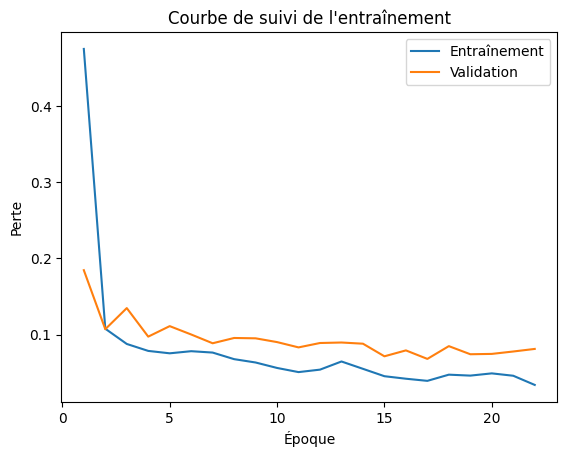

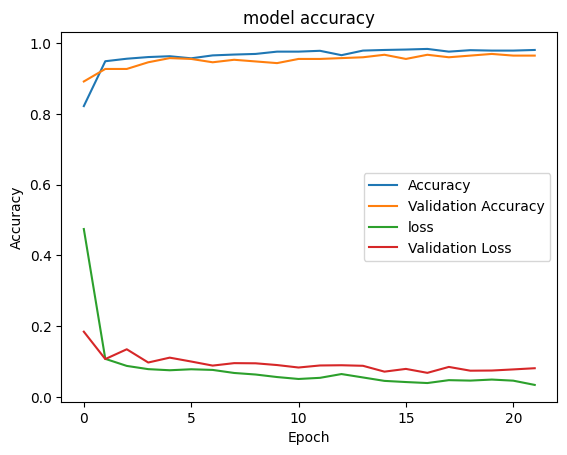

In [41]:
# Extract the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Entraînement')
plt.plot(epochs, validation_loss, label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbe de suivi de l\'entraînement')
plt.legend()
plt.show()
# Plot the training and validation loss
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# Assuming y_true and y_pred are your actual and predicted labels
# Example data, replace these with your actual data
y_true = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3]
y_pred = [0, 1, 2, 3, 4, 0, 1, 2, 3, 5]

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

# Print classification report
target_names = ['Engaged', 'Confused', 'Frustrated', 'Bored', 'Drowsy', 'Looking away']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Confusion Matrix:
[[1 1 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]]

Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

     Engaged       0.50      0.50      0.50         2
    Confused       0.50      0.50      0.50         2
  Frustrated       0.50      0.50      0.50         2
       Bored       0.50      0.50      0.50         2
      Drowsy       1.00      1.00      1.00         1
Looking away       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.50        10
weighted avg       0.50      0.50      0.50        10



In [ ]:
#Train CNN using data-augmentation
# Create an instance of the ImageDataGenerator for data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for training data with data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    #class_mode='binary',  # Assuming binary classification
    shuffle=True  # Set to True for training data
)


# Compile your model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train your model using the augmented dataset
model.fit(train_generator, epochs=100, callbacks=[tensorboard_callback, early_stopping])


Found 2120 images belonging to 6 classes.
Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.1962

67/67 [==============================] - 28s 393ms/step - loss: 0.4629 - accuracy: 0.1962
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.2297

67/67 [==============================] - 27s 395ms/step - loss: 0.4446 - accuracy: 0.2297
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.3976

67/67 [==============================] - 27s 406ms/step - loss: 0.3724 - accuracy: 0.3976
Epoch 4/100
67/67 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.5019

67/67 [==============================] - 27s 407ms/step - loss: 0.2991 - accuracy: 0.5019
Epoch 5/100
67/67 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.5524

67/67 [==============================] - 27s 408ms/step - loss: 0.2801 - accuracy: 0.5524
Epoch 6/100
67/67 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.5623

67/67 [==============================] - 28s 411ms/step - loss: 0.2724 - accuracy: 0.5623
Epoch 7/100
67/67 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.6198

67/67 [==============================] - 27s 408ms/step - loss: 0.2595 - accuracy: 0.6198
Epoch 8/100
67/67 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.6132

67/67 [==============================] - 27s 409ms/step - loss: 0.2525 - accuracy: 0.6132
Epoch 9/100
67/67 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.6075

67/67 [==============================] - 27s 411ms/step - loss: 0.2559 - accuracy: 0.6075
Epoch 10/100
67/67 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.6066

67/67 [==============================] - 27s 405ms/step - loss: 0.2502 - accuracy: 0.6066
Epoch 11/100
67/67 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.6524

67/67 [==============================] - 27s 404ms/step - loss: 0.2377 - accuracy: 0.6524
Epoch 12/100
67/67 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.6491

67/67 [==============================] - 27s 411ms/step - loss: 0.2340 - accuracy: 0.6491
Epoch 13/100
67/67 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.6929

67/67 [==============================] - 28s 411ms/step - loss: 0.2099 - accuracy: 0.6929
Epoch 14/100
67/67 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.6741

67/67 [==============================] - 28s 420ms/step - loss: 0.2191 - accuracy: 0.6741
Epoch 15/100
67/67 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.7061

67/67 [==============================] - 28s 415ms/step - loss: 0.2021 - accuracy: 0.7061
Epoch 16/100
67/67 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.6915

67/67 [==============================] - 27s 409ms/step - loss: 0.2143 - accuracy: 0.6915
Epoch 17/100
67/67 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.7259

67/67 [==============================] - 28s 411ms/step - loss: 0.1954 - accuracy: 0.7259
Epoch 18/100
67/67 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.7245

67/67 [==============================] - 27s 407ms/step - loss: 0.1958 - accuracy: 0.7245
Epoch 19/100
67/67 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.7453

67/67 [==============================] - 27s 411ms/step - loss: 0.1845 - accuracy: 0.7453
Epoch 20/100
67/67 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.7316

67/67 [==============================] - 30s 447ms/step - loss: 0.1889 - accuracy: 0.7316
Epoch 21/100
67/67 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.7623

67/67 [==============================] - 26s 390ms/step - loss: 0.1801 - accuracy: 0.7623
Epoch 22/100
67/67 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.7491

67/67 [==============================] - 28s 407ms/step - loss: 0.1845 - accuracy: 0.7491
Epoch 23/100
67/67 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.7439

67/67 [==============================] - 27s 404ms/step - loss: 0.1806 - accuracy: 0.7439
Epoch 24/100


**After data augmantation**

Number of augmented samples: 67
Class 0: 423 samples
Class 1: 358 samples
Class 2: 369 samples
Class 3: 263 samples
Class 4: 347 samples
Class 5: 360 samples
Number of original samples: 2120
Batch size during training: 32
Number of augmented samples per epoch: 67840
Number of epochs: 100
Total number of augmented samples: 6784000


<ipython-input-38-7f71695e6234>:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  count = sum(1 for label in class_distribution if label == class_label)


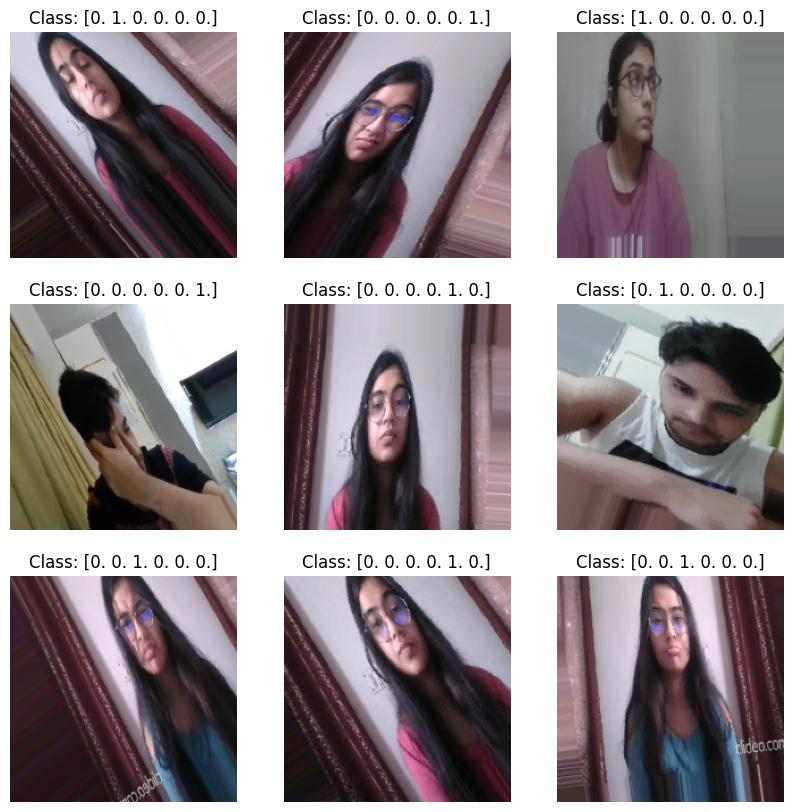

In [38]:
#The number of samples in your dataset after applying data augmentation.
num_original_samples = len(train_generator.filenames)  # Number of original samples in your dataset
batch_size = train_generator.batch_size  # Batch size used during training
num_augmented_samples_per_epoch = num_original_samples * batch_size
num_epochs = 100  # Replace with the actual number of epochs
total_augmented_samples = num_epochs * num_augmented_samples_per_epoch

# Number of Samples:
num_samples = len(train_generator)
print("Number of augmented samples:", num_samples)

#Class Distribution:
class_distribution = train_generator.classes
unique_classes = set(class_distribution)

for class_label in unique_classes:
    count = sum(1 for label in class_distribution if label == class_label)
    print(f"Class {class_label}: {count} samples")

# Print the results
print("Number of original samples:", num_original_samples)
print("Batch size during training:", batch_size)
print("Number of augmented samples per epoch:", num_augmented_samples_per_epoch)
print("Number of epochs:", num_epochs)
print("Total number of augmented samples:", total_augmented_samples)


#Visual Inspection:
import matplotlib.pyplot as plt

# Display a few augmented images
images, labels = train_generator.next()

plt.figure(figsize=(10, 10))
for i in range(min(9, batch_size)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i]}")
    plt.axis("off")

plt.show()


In [ ]:
# Cette ligne importe la bibliothèque "files" de Google Colab, qui permet de charger des fichiers depuis votre ordinateur vers l'environnement Colab.
from google.colab import files
# Cette ligne demande à l'utilisateur de télécharger un fichier (une image dans ce cas) vers l'environnement Colab. Le fichier téléchargé sera stocké dans la variable file_to_predict.
file_to_predict = files.upload()
# Cette ligne itère sur les fichiers téléchargés (dans le cas où plusieurs fichiers auraient été téléchargés) et effectue les étapes suivantes pour chaque fichier.
for file_ in file_to_predict:
  #Cette ligne utilise la fonction cv2.imread de la bibliothèque OpenCV pour lire l'image téléchargée à partir du fichier.
  #L'image est stockée dans la variable image_to_predict.
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    #Cette ligne affiche l'image en utilisant plt.imshow de la bibliothèque matplotlib.
    #cv2.cvtColor est utilisé pour convertir l'image du format BGR (utilisé par OpenCV) en format RGB (utilisé par matplotlib).
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    #Cette ligne redimensionne l'image à une taille de 200x200 pixels à l'aide de cv2.resize et l'expands en ajoutant une dimension supplémentaire à l'aide de np.expand_dims.
    #Cela est nécessaire pour que l'image corresponde à la forme attendue par le modèle (une seule image avec les dimensions spécifiées).
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0)
    #Cette ligne effectue la prédiction en utilisant le modèle CNN entraîné (model.predict). La variable res contient les résultats de la prédiction.
    res = model.predict(img_to_predict)
predicted_class = np.argmax(res)  # Obtient l'indice de la classe prédite avec la plus haute probabilité
if predicted_class == 0:
    plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Engaged!")
elif predicted_class == 1:
    plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Not engaged!")
#Ce code permet de charger une image, de faire des prédictions avec le modèle CNN et d'afficher une image correspondant